## SIFT 알고리즘이란?

* SIFT (Scale-Invariant Feature Transform)은 `이미지의 크기와 회전에 불변`하는 특징을 추출하는 알고리즘입니다.

* 서로 다른 두 이미지에서 SIFT 특징을 각각 추출한 다음에 서로 가장 비슷한 특징끼리 매칭해주면 두 이미지에서 대응되는 부분을 찾을 수 있다는 것이 기본 원리입니다.



## Harris Corner의 Invariance & covariance

### 불변성과 공변성

1. 불변성(Invariance)

    * 광도 변환에 상관없이 동일한 코너가 검출되어야 함.


2. 공변성(Covariance)

    * 기하학적 변환에 상관없이 동일한 코너가 검출되어야 함

### Harris Corner의 불변성과 공변성

1. **Affine intensity change** (광도의 선형적 변환)
$$
I = aI + b
$$

    * 미분 연산만이 수행된 경우 `b`에 대해서는 불변성을 가지나, `a`에 대해서는 불변성을 가지지 않음

    * 다시말해, `intensity shift에 대해서는 불변성`을, `intensity scaling에 대해서는 불변성을 가지지 않음`.

2. Image translation & rotation

    * `이미지 이동에 대해서 공변성을 가짐`.

    * 이미지 회전의 경우 고유 값은 그대로이며 고유 벡터의 방향만 변화하므로 `회전에 대해서 공변성을 가짐`.

3. **Scaling**
    
    * `동일한 응답값을 갖는 영상 패치크기를 각각 찾아 매칭시키는 것은 연산량이 매우 커진다`.

    * 또한 `특정 영상 간에 의존적인 결과`를 나타내므로 다양한 영상간의 특징점 매칭을 하기 위해 또 다른 연산이 수행되어야 한다.

    * 영상마다 한 번의 특징 검출로 다른 영상과 매칭할 수 있는 방법이 필요하다.

Original Center: (112, 112)
Downsampled Center: (56, 56)


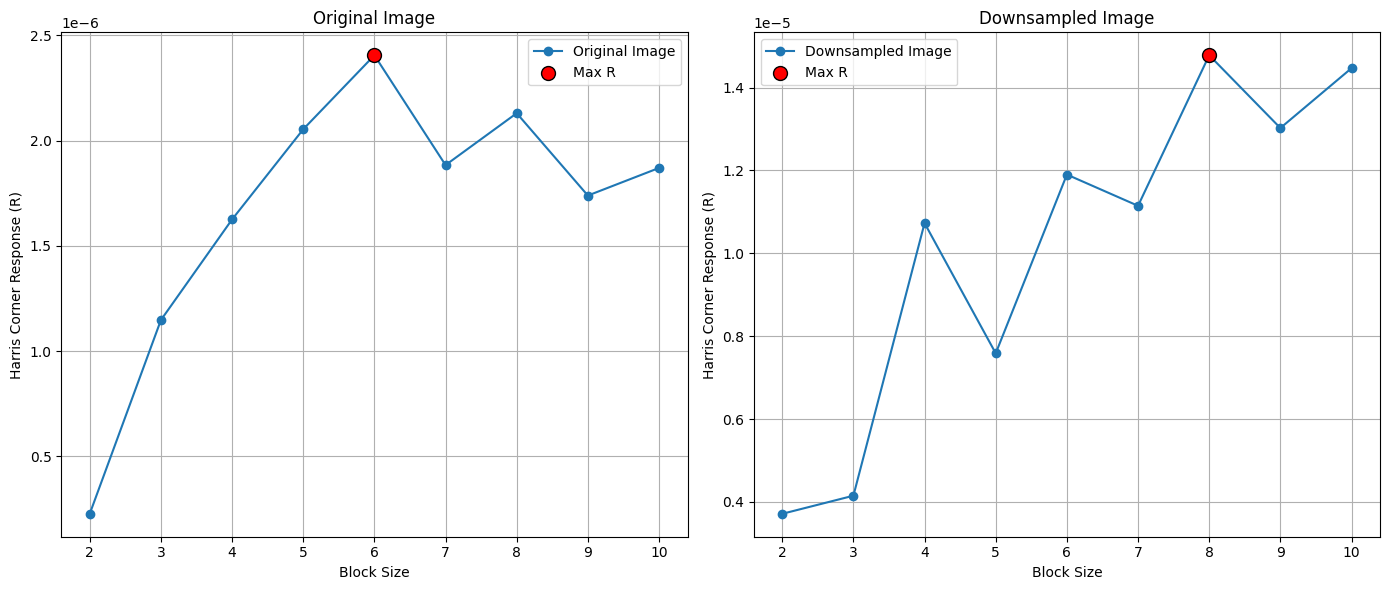

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 이미지 불러오기
image_path = '/content/drive/MyDrive/Image/low_pixel_image.jfif'  # 이미지 경로
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 순서를 사용하므로 RGB로 변환

# 2. 다운샘플링
downsampled_image = cv2.pyrDown(image_rgb)  # 2배로 다운샘플링 (가로, 세로 모두 절반)

# 3. 좌표 설정 및 변환
height, width = image_rgb.shape[:2]
original_center = (width // 2, height // 2)  # 원본 이미지에서의 좌표 (예: 중심 좌표)
downsampled_center = (original_center[0] // 2, original_center[1] // 2)  # 다운샘플링 후의 좌표

# 결과 출력
print("Original Center:", original_center)
print("Downsampled Center:", downsampled_center)

# 4. Harris Corner 응답 계산 함수
def harris_response_at_point(image, point, blockSize, ksize=3, k=0.04):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    R_map = cv2.cornerHarris(gray, blockSize, ksize, k)
    R_value = R_map[point[1], point[0]]  # 주어진 좌표의 Harris 응답값 R을 추출
    return R_value

# 5. blockSize를 변화시키며 Harris 응답 계산
block_sizes = range(2, 11)
R_values_original = []
R_values_downsampled = []

for blockSize in block_sizes:
    # 원본 이미지의 Harris 응답값 계산
    R_original = harris_response_at_point(image_rgb, original_center, blockSize)
    R_values_original.append(R_original)

    # 다운샘플링된 이미지의 Harris 응답값 계산
    R_downsampled = harris_response_at_point(downsampled_image, downsampled_center, blockSize)
    R_values_downsampled.append(R_downsampled)

# 6. 시각화
plt.figure(figsize=(14, 6))

# 원본 이미지에 대한 Harris 응답값 그래프
plt.subplot(1, 2, 1)
plt.plot(block_sizes, R_values_original, marker='o', label='Original Image')
plt.xlabel('Block Size')
plt.ylabel('Harris Corner Response (R)')
plt.title('Original Image')
plt.grid(True)
# 최대값 표시
max_idx_original = np.argmax(R_values_original)
plt.scatter(block_sizes[max_idx_original], R_values_original[max_idx_original],
            color='red', s=100, edgecolor='black', zorder=5, label='Max R')
plt.legend()

# 다운샘플링된 이미지에 대한 Harris 응답값 그래프
plt.subplot(1, 2, 2)
plt.plot(block_sizes, R_values_downsampled, marker='o', label='Downsampled Image')
plt.xlabel('Block Size')
plt.ylabel('Harris Corner Response (R)')
plt.title('Downsampled Image')
plt.grid(True)
# 최대값 표시
max_idx_downsampled = np.argmax(R_values_downsampled)
plt.scatter(block_sizes[max_idx_downsampled], R_values_downsampled[max_idx_downsampled],
            color='red', s=100, edgecolor='black', zorder=5, label='Max R')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display, HTML
from google.colab import drive

display(HTML('''
<style>
.markdown-cell .rendered_html {
    font-family: "D2Coding", sans-serif;
    font-size: 16px;
}
</style>
'''))


# Introduction


For starters, what even is SIFT? SIFT, which stands for Scale Invariant Feature Transform, is a method for extracting feature vectors that describe local patches of an image. Not only are these feature vectors scale-invariant, but they are also invariant to translation, rotation, and illumination. Pretty much the holy grail for a descriptor.


These descriptors are useful for matching objects are patches between images. For example, consider creating a panorama. Assuming each image has some overlapping parts, you need some way to align them so we can stitch them together. If we have some points in each image that we know correspond, we can warp one of the images using a homography. SIFT helps with automatically finding not only corresponding points in each image, but points that are easy to match.

![alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*pwOhfFcv28p90fgwWhBzzw.png)

![alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*5LTZZiJIGUNnPXr_EGm_nQ.png)

# Description of the Algorithm



This document is based on https://lerner98.medium.com/implementing-sift-in-python-36c619df7945

As described on Wikipedia: https://en.wikipedia.org/wiki/Scale-invariant_feature_transform, the SIFT algorithm has four main steps:

1. Sclae-Space Extrema Detection
2. Keypoint Localization
3. Orientation Assignment
4. Local Descriptor Creation

#Scale-Space Extrema Detection




The characteristic scale of a feature can be detected using a scale-normalized Laplacian-of-Gaussian (LoG) filter. This is what the LoG filter looks like:

| 특징점의 특성 스케일은 스케일 정규화된 Laplacian-of-Gaussian (LoG) 필터를 사용하여 검출할 수 있다. 아래는 LoG 필터의 형태를 나타낸 것이다.

![alt text](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*nBfErR8RyTc05d82owhDWw.png)

The LoG filter is highly peaked at the center while becoming slightly negative and then zero at a distance from the center characterized by the standard deviation, sigma, of the Gaussian

| LoG 필터는 중앙에서 강한 피크를 이루며 가우시안의 시그마 $(\sigma)$ 에 따라 중앙으로부터 멀어질 수록 값이 약간 음수가 되었다가 0으로 수렴하는 형태를 갖는다.

Therefore, the LoG filter is most higly activated by a circle, or BLOB, with radius proportional to sigma. However, the Gaussian is normalized, i.e. if you integrate it over all space it sum to one. Therefore, with a higer simga and therfore a wider Gaussian, the response of the LoG fitler for that Gaussian will be lower than for a smaller sigma. Therefore, SIFT uses the **scale-normalized** LoG filter which is the regular LoG multiplied by variance(sigma squared).

| 그러므로 LoG 필터는 시그마$(\sigma)$에 비례하는 반경을 가진 BLOB, 원 형태를 검출할 때 가장 강하게 활성화 된다. 그러나 가우시안은 정규화되어 있어, 모든 공간에 대해 적분하면 1이 된다. 따라서, 시그마가 커지면 가우시안이 더 넓어지기 때문에 LoG 필터의 응답값은 작은 시그마를 사용하는 경우보다 작아진다.  이러한 이유로, SIFT는 LoG 필터에 분산(σ²)에 따른 가우시안을 합성곱한 **크기 정규화된 LoG 필터**를 사용한다.

## 1.1 Laplacian-of-Gaussian(LoG) filter

## 1.2 DoG Approximation





While the scale-normalized LoG is fine and dandy, it is expensive to compute, especially since we need to calculate it at many different scales. Thankfully, the authors of SIFT came up with a clever way to efficiently calculate the LoG at many scales.

| 크기 정규화된 LoG는 성능이 좋지만 연산량이 많아 특히 여러 크기에서 이를 계산해야 할 때 부담이 된다. 다행히도, SIFT의 저자들은 여러 스케일에서 LoG를 효율적으로 계산할 수 있는 영리한 방법을 고안해냈다.

It turns out that the difference of two Gaussians with similar variance yields a filter that approximates the scale-normalized LoG very well:

| 비슷한 분산을 가진 두 가우시안의 차이를 사용하면 크기 정규화된 LoG를 매우 잘 근사하는 필터를 만들 수 있다는 사실을 알아냈다.

![alt text](https://miro.medium.com/max/625/1*jFQVYG7VrXs44V0Qbr1GUQ.gif)


## 1.3 DoG pyramid



Now that we have an efficient way to approximate the LoG, we need to compute it at multiple scales. SIFT uses a number of octaves to calculate the DoG. Most people would think that an octave means that eight images are computed. However, **an octave is actually a set of images were the blur of the last image is double the blur of the first image.**

| 이제 우리는 LoG를 효율적으로 근사하는 방법을 알았으므로, 이를 여러 스케일에서 계산해야 한다. SIFT는 DoG를 계산하기 위해 여러 옥타브(octave)를 사용한다. 대부분의 사람들은 옥타브가 8개의 이미지를 의미한다고 생각하지만, 실제로 **옥타브는 첫 번째 이미지보다 두 배 더 블러 처리된 마지막 이미지를 포함한 이미지 세트**를 의미한다.

To create this octave, we first need to choose the number of images we want in each octave. This is denoted by s. Then the sigma for the Gaussian filter is chosen to be 2^(1/s). Since blur accumulates multiplicatively, when we blur the original image with this filter s times, the result will have blur = 2 * original blur.

| 이러한 octave를 생성하기 위해 먼저 우리는 각 octave에 생성할 이미지의 수를 결정해야 한다. 이를 s라고 하자. 그러면 가우시안 필터의 $\sigma$는 $2^{\frac{1}{s}}$로 결정된다. 블러가 곱셈적으로 축적되기 때문에, $\sigma$를  $2^{\frac{1}{s}}$로 하여 원본 이미지를 s번 블러처리하면 결과는 원본이미지의 2배 블러처리된 이미지를 가진다.

One detail from the paper that I rarely see mentioned is that in each octave, you actually need to produce s+3 images (including the original image). This is because when adjacent levels are subtracted to obtain the approximated LoG octave, we will get one less image than in the Gaussian octave:

| 논문에서 드물게 언급된 한 가지 세부사항은 각각의 octave에서 실제로 s + 3 개의 이미지를 만들어야 한다는 것이다.(원본 이미지를 포함함) 이는 인접한 레벨을 빼서 근사된 LoG 옥타브를 얻을 때, 가우시안 옥타브의 이미지보다 하나 적은 이미지를 얻기 때문이다.

![alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*vzUvEVlZWbfCDBO44fIdcw.png)

Now we have s+2 images in the DoG octave. However, later when we look for extrema in the DoG, we will look for the min or max of a neighborhood specified by the current and adjacent levels. Obviously, this neighborhood cannot be obtained at the top or bottom level, so we have these two extra levels so that the neighborhood is defined over a full octave in the scale space. This will be more clear in the next section.

| 이제 DoG 옥타브에서 s+2개의 이미지를 얻었다. 이후 DoG에서 극값을 찾을 때, 현재 레벨과 인접한 레벨에서 정의된 이웃에서 극소값이나 극대값을 찾게 된다. 하지만, 이 이웃은 옥타브의 최상위 또는 최하위 레벨에서 정의될 수 없기 때문에, 이 두 개의 여분의 레벨이 필요하다. 이렇게 함으로써, 스케일 공간에서 전체 옥타브에 걸쳐 이웃이 정의될 수 있게 된다. 이 부분은 다음 섹션에서 더 명확해질 것이다.

After we have generated the Gaussian octave, we downsample the top level by two and use that as the bottom level for a new octave. The original paper uses four octaves. These octaves make up what I call the Gaussian pyramid.

| 가우시안 옥타브를 생성한 후, 최상위 레벨을 2배로 다운샘플링하여 새로운 옥타브의 최하위 레벨로 사용한다. 원본 논문에서는 4개의 옥타브를 사용하고 있으며, 이러한 옥타브는 우리가 '가우시안 피라미드'라고 부르는 구조를 형성한다.

## 1.4 Gaussian filter



Finally we are getting to some code. First, we obviously need a Gaussian filter for creation of the Gaussian octave:

먼저, Gaussian octave를 만들기 위해 Gaussian filter가 필요하다.

In [ ]:
import numpy as np
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
from skimage import data, filters, color
from skimage import io
import numpy.linalg as LA

In [ ]:
def gaussian_filter(sigma):
    #np.ceil : 반올림.
    size = 2*np.ceil(3*sigma)+1

    #np.mgrid : 격자 생성 (좌표계 생성)
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)

    return g/g.sum()

print('Definition of gaussian filter=', gaussian_filter(1))

Definition of gaussian filter= [[1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [1.76900911e-03 2.15509428e-02 9.65846250e-02 1.59241126e-01
  9.65846250e-02 2.15509428e-02 1.76900911e-03]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]]


Next, to generate a Gaussian octave, we simply need to select sigma (or k as it is called in the paper) and repeatedly convolve with this Gaussian filter:

다음으로, Gaussian octave를 생성하기 위해 시그마(σ) 또는 논문에서 언급된 k 값을 선택하고 이 가우시안 필터와 반복적으로 합성곱한다.

Just as in the paper, I use an s of 5. One other thing to note is sigma parameter. This parameter is used to scale k so that the blur in each DoG octave goes from sigma -> 2*sigma. I use a value of 1.6 for sigma. Then to generate the whole Gaussian pyramid:

논문에서처럼, s 값을 5로 설정했다. 주목해야 할 또 다른 점은 시그마(σ) 매개변수이다. 이 매개변수는 k를 스케일링하는 데 사용되며, 이를 통해 각 DoG octave의 블러는 $\sigma$에서 $2*\sigma$로 변한다. 다음 코드에서는 $\sigma$ 값을 1.6으로 설정했다. 그런 다음 전체 Gaussian 피라미드를 생성한다:

In [ ]:
def generate_octave(init_level, s, sigma):

    octave = [init_level]
    k = 2**(1/s)
    kernel = gaussian_filter(k * sigma)

    #octave 가장 마지막과 kernel의 convolution 연산하여 octave 가장 뒤에 이어붙인다.

    #s + 2번 하면 s + 3장 만들어짐
    for _ in range(s + 2):
        #convolve 함수 내부적으로 padding 함.(이미지 크기 변화 x)
        next_level = convolve(octave[-1], kernel)
        octave.append(next_level)

    return octave


## 1.5 Generation of Gaussian Octave

In [ ]:
from matplotlib import pyplot as plt

#for test of gaussian_filter()
def draw_octave(octave):
    n = len(octave)
    rows, cols = (2, n//2)
    fig_width = 3*cols
    fig_height = 3*rows*octave[0].shape[0]//octave[0].shape[1]
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

    for i in range(n):
        ax = axs[i//cols, i%cols]
        ax.set_title(f'Octave {i}')
        ax.imshow(octave[i], cmap='gray')
    plt.show()

def draw_octave1D(octave, sharex=False, sharey=False):
    n = len(octave)
    rows, cols = (2, n // 2)
    fig_width = 3 * cols
    fig_height = 3 * rows * octave[0].shape[0] // octave[0].shape[1]
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=sharex, sharey=sharey)

    for i in range(n):
        ax = axs[i // cols, i % cols]
        ax.set_title(f'Octave {i}')

        # y 데이터를 1D로 변환 (세로 중앙의 데이터)
        y_data = octave[i][octave[i].shape[0] // 2, :]

        length = len(y_data)
        if length % 2 == 0:
            x_data = np.arange(-length // 2, length // 2)
        else:
            x_data = np.arange(-(length // 2), length // 2 + 1)


        ax.plot(x_data, y_data)

    plt.show()

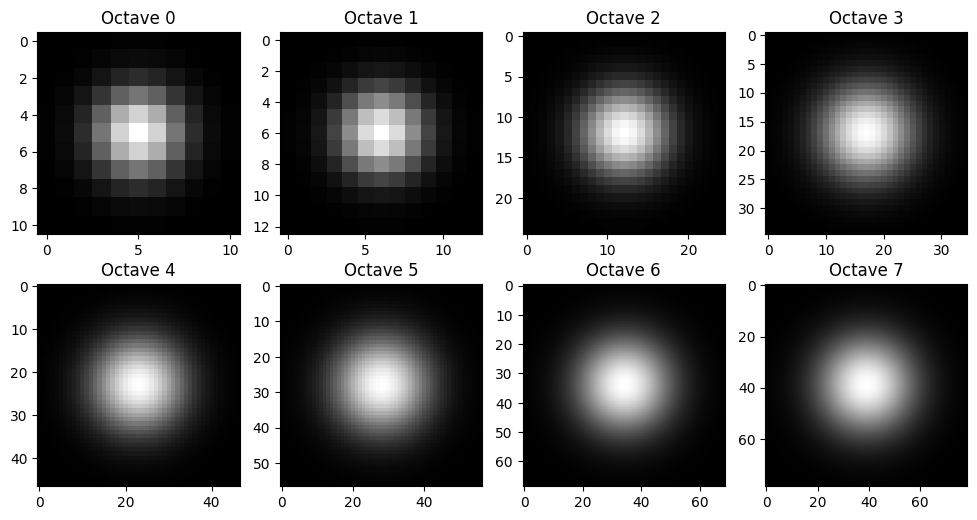

In [ ]:
s = 5
sigma = 1.6
#gauss_octave = generate_octave(gaussian_filter(sigma), s, sigma)
gauss_octave = [gaussian_filter(sigma)]


#genterate_octave 안쓰고 매번 시그마 바꾸어가며 구하기

#sigma가 커지니 kernel scale도 커진다.
k = 2**(1/5)

for i in range(s+2):
    gauss_octave.append(gaussian_filter(k*(i+1)*sigma))

draw_octave(gauss_octave)

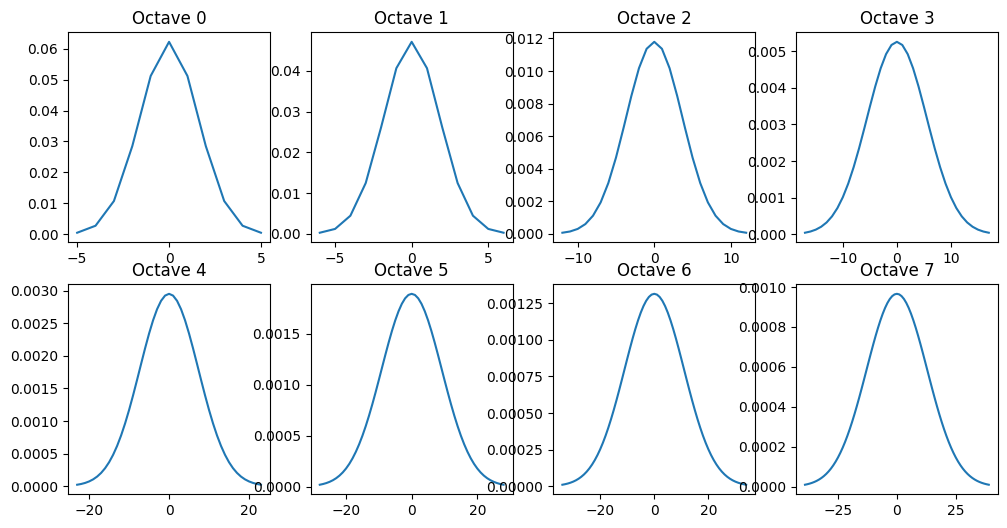

In [ ]:
draw_octave1D(gauss_octave)

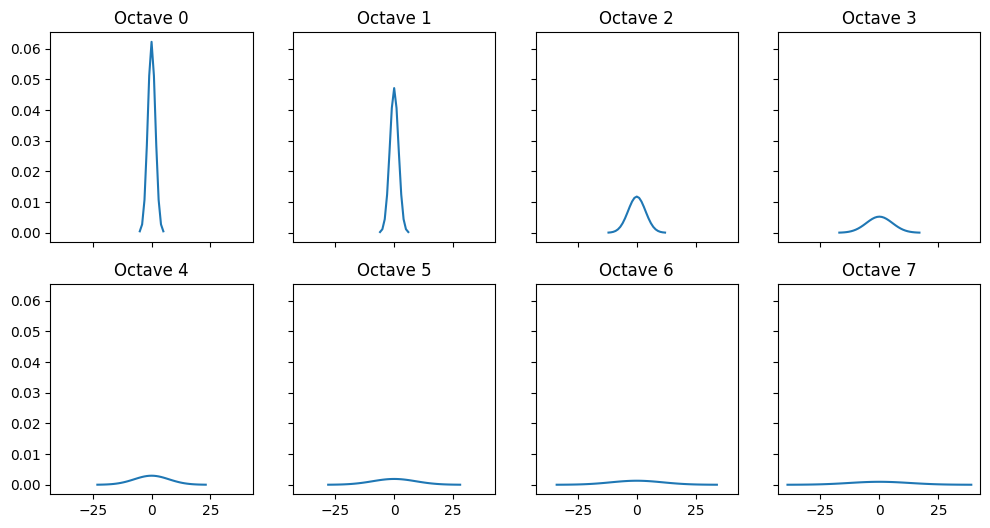

In [ ]:
draw_octave1D(gauss_octave, sharex=True, sharey=True)

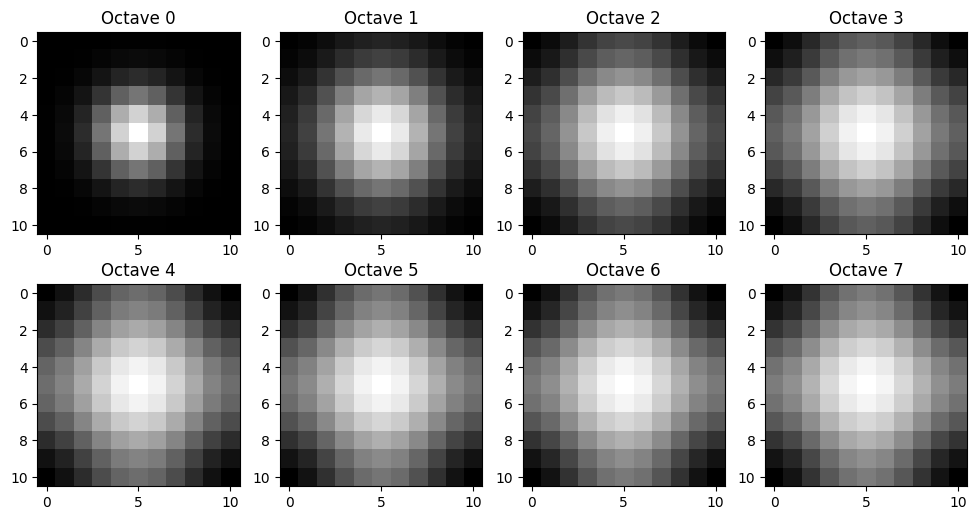

In [ ]:
#reguler Gaussian filter를 sigma에 따라 convolution 연산하여 scale-normalized
gauss_octave = generate_octave(gaussian_filter(sigma), s, sigma)
draw_octave(gauss_octave)

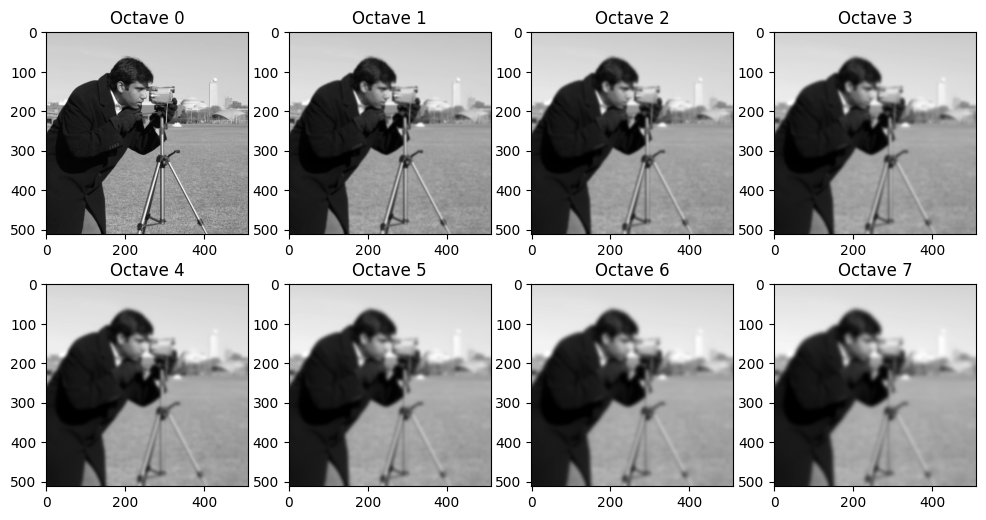

In [ ]:
from skimage import data, filters, color
from skimage import io

image = data.camera()

octave = generate_octave(image, 5, 1.6)  #s = 5 ,sigma = 1.6

draw_octave(octave)

## 1.6 Generation of Gaussian Pyramid

* Just as in the paper, we use an $s$ of 5. One other thing to note is `sigma parameter`. This parameter is used to scale $k$ so that th blur in each DoG octave goes from $\sigma \rightarrow 2 *\sigma$. I use a value of 1.6 for $\sigma$. Then to generate the whole Gaussian pyramid:

![alt text](https://miro.medium.com/max/1206/1*vzUvEVlZWbfCDBO44fIdcw.png)


 * octave[-3] is the $s + 1$th image in the current octave that has a scale which has twice the blur of the first image.

 * In the SIFT algorithm, the level in each octave where $k^s = 2$ (i.e., the scale has doubled from the first image) is downsampled to be used as the first image in the next octave.

 * This ensures continuity between successive octaves and allows the algorithm to efficiently detect features across different scales.

In [ ]:
def generate_gaussian_pyramid(im, num_octave, s, sigma):

    #피라미드를 넣을 리스트 생성
    pyr = []

    #octave 당 s + 3개의 layer 생성되며 s + 1번째 layer에서 downsampling
    for _ in range(num_octave):
        octave = generate_octave(im, s, sigma)
        pyr.append(octave)
        im = octave[-3][::2, ::2]
    return pyr

In [ ]:
def generate_DoG_octave(gaussian_octave):

    #DoG 옥타브를 저장할 빈 리스트 생성
    octave = []

    #현재 레벨의 가우시안 이미지에서 이전 가우시안 이미지를 뺌

    #만약 gaussian_octave가 [G0, G1, G2, ..., Gn]이라면, DoG 옥타브는 [G1 - G0, G2 - G1, ..., Gn - Gn-1]

    for i in range(1, len(gaussian_octave)):
        octave.append(gaussian_octave[i] - gaussian_octave[i-1])

    #cv2.merge랑 같다. 3차원 결합
    return np.concatenate([o[:,:,np.newaxis].astype(np.float32) for o in octave], axis=2)

def generate_DoG_pyramid(gaussian_pyramid):
    pyr = []

    for gaussian_octave in gaussian_pyramid:
        pyr.append(generate_DoG_octave(gaussian_octave))

    return pyr

Gaussian Pyramid
Octave 3


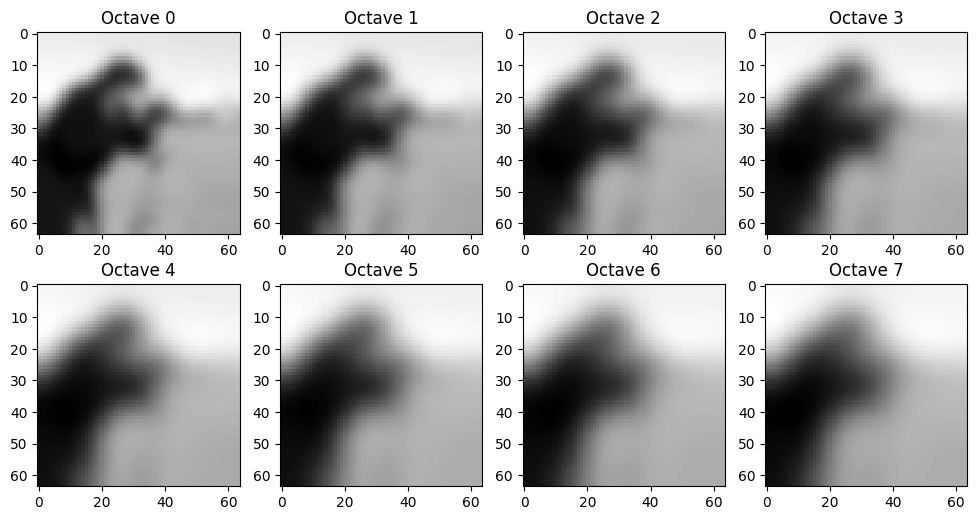

Octave 2


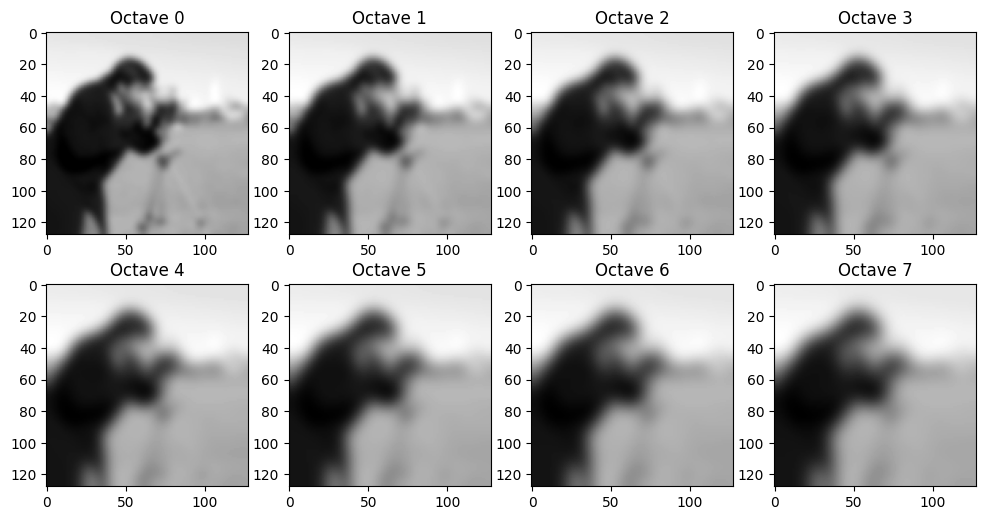

Octave 1


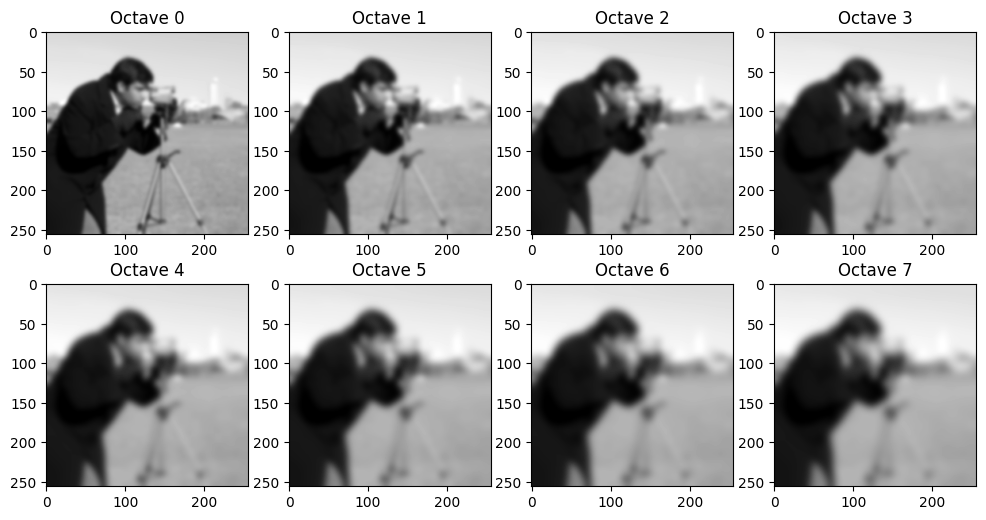

Octave 0


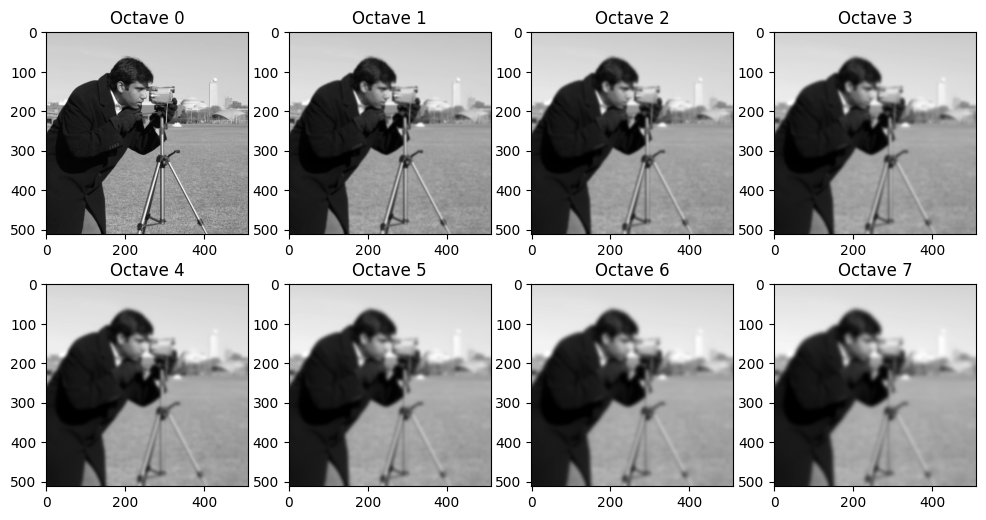

In [ ]:
#test for generate_DoG_octave

g_pyr = generate_gaussian_pyramid(image, 4, 5, 1.6) #num_octave = 4, s = 5, sigma = 1.6

dog_pyr = generate_DoG_pyramid(g_pyr)

print('Gaussian Pyramid')
for i in range(len(g_pyr)-1, -1, -1):
    print(f'Octave {i}')
    draw_octave(g_pyr[i])

DoG pyramind
Octave 3


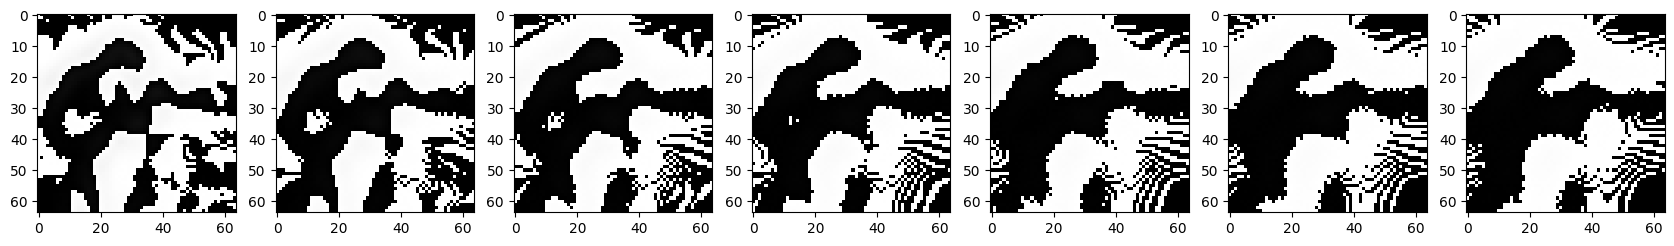

Octave 2


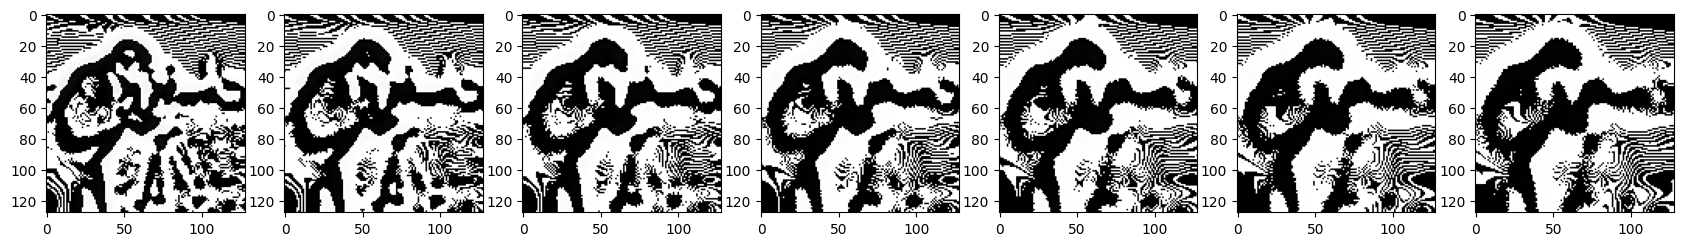

Octave 1


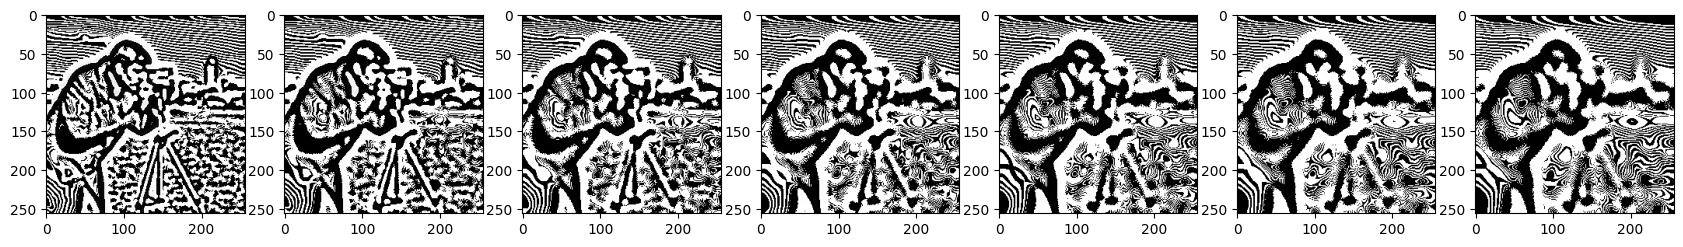

Octave 0


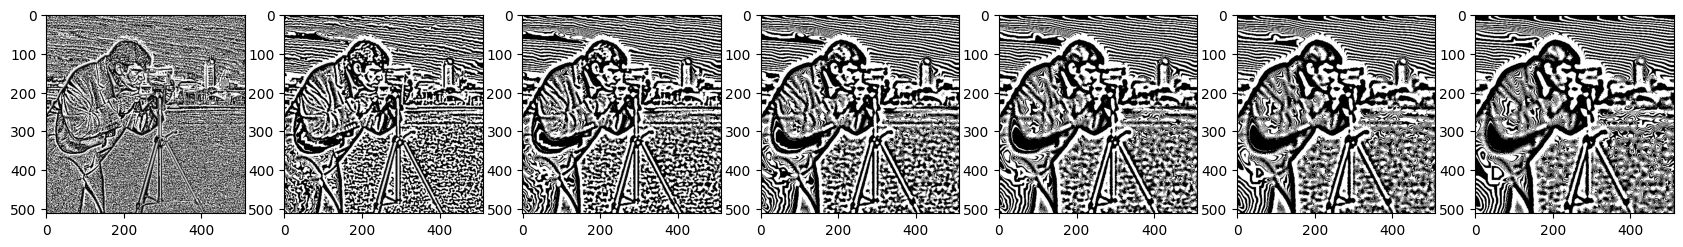

In [ ]:
def draw_octaveDoG(octave):
    n = octave.shape[2]
    fig, axs = plt.subplots(1, n, figsize=(3*n, 3))

    for i in range(n):
        axs[i].imshow(octave[:,:,i], cmap='gray')
    plt.show()

print('DoG pyramind')
for i in range(len(dog_pyr)-1, -1, -1):
    print(f'Octave {i}')
    draw_octaveDoG(dog_pyr[i])

## 1.7 Extrema Detectaion

The first step in extrema detection is to scan over each scale-space DoG octave, $D$, and include the center of each 3x3x3 neighborhood as a keypoint if it is the minimum or maximum value in neighborhood.

![alt text](https://miro.medium.com/max/468/1*kwBQSL5U-QGSLd-ovlAHFw.png)

This is why we generated $s+2$ levels in the DoG octave, since we cannot scan over the points in the tp or botteom level, but we still want to get keypoints over a full octave of blur.

In [ ]:
def get_candidate_keypoints(D, w=16):
    #D는 한 옥타브를 말하며, w은 윈도우 크기입니다.

    candidates = []

    #옥타브의 처음과 마지막을 0으로 합니다.
    #옥타브 shape은 (height, width, layer)입니다.
    D[:, :, 0] = 0
    D[:, :, -1] = 0


    #상하 좌우 패딩
    for i in range(w//2+1, D.shape[0]-w//2-1):
        for j in range(w//2+1, D.shape[1]-w//2-1):
            for k in range(1, D.shape[2]-1):
                patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
                if np.argmax(patch) == 13 or np.argmin(patch) == 13:
                    candidates.append([i, j, k])

    return candidates

Mr.Sam Lerner has a few things to say about this code:

1. He set the **top and bottom extra levels to 0** because he was initially only getting extrema in those levels. This is probably due an incorrect construction of th DoG octave, but it seems to work well enough.

2. Instead of scanning with a padding of one on each level, **we have a padding of $w/2$** where $w$ is the side length for the patches used when creating local descriptors. Without this, I was getting out of bounds errors.

3. Calling `argmax` or `argmin` without an axis parameter runs on the flattened array. Since our neighborhood is 3x3x3, or 27 elements long, **when the extrema is our inspected pixel, the value of argmax or argmin will be 13**

These candidate keypoints yield many poor choices and/or noisy, so in the next section we will throw out bad ones as well refine good ones

In [ ]:
# this function will be updated later
def find_keypoints_for_DoG_octave(D, w):
    #특징점 후보 추출
    candidates = get_candidate_keypoints(D, w)
    keypoints = []

    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]

        kp = np.array([x, y, s])
        keypoints.append(kp)

    #candidates에서 y, x 좌표를 변환해서 출력하는 것임.
    return np.array(keypoints)

In [ ]:
def get_keypoints(DoG_pyr, w):
    kps = []

    #DoG_pyr (피라미드 수 * D(height, width, 옥타브 수))
    for D in DoG_pyr:
        kps.append(find_keypoints_for_DoG_octave(D, w))

    return kps

In [ ]:
from skimage import data, filters, color
from skimage import io

gimage = data.camera()
kernel = gaussian_filter(1.3)
gray_image = convolve(gimage, kernel)
g_pyramid = generate_gaussian_pyramid(gray_image, num_octave=4, s=5, sigma=1.6)
dog_pyramid = generate_DoG_pyramid(g_pyramid)
kps = get_keypoints(dog_pyramid, 16) #w = 16


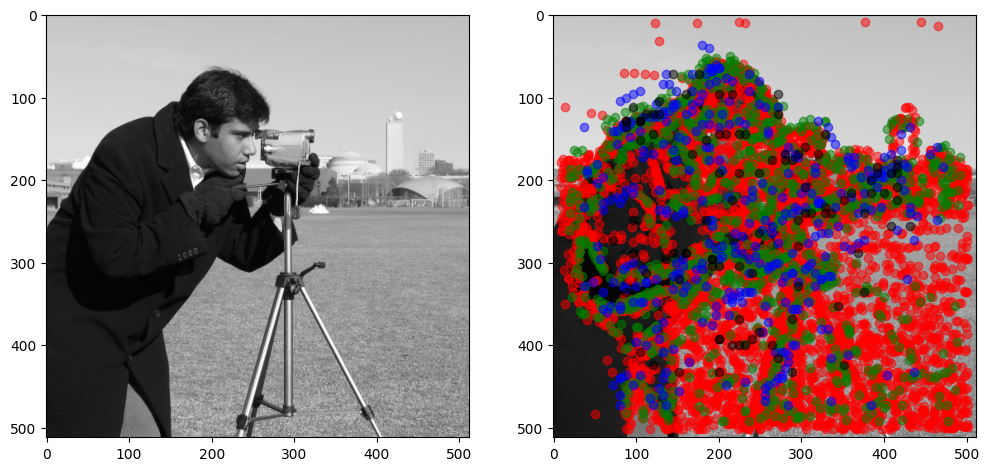

In [ ]:
def myDrawKeypoints(image, kps):
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs[0].imshow(image, cmap='gray')
    axs[1].imshow(image, cmap='gray')
    h = image.shape[0]

    colors = ['red', 'green', 'blue', 'black']
    for o in range(len(kps)):
        if len(kps[o]) == 0:
            continue
        #downsampling 과정에서 원본보다 크기가 2**o 배 줄어들었다. 따라서 좌표 변환을 위해 다음과 같은 연산이 필요하다.
        kpso = kps[o]*(2**o)
        for pt in kpso:
            axs[1].scatter(pt[0], pt[1], color=colors[o], alpha = 0.5)

myDrawKeypoints(gimage, kps)

# 2. Keypoint Localization

We will perform three steps to get better keypoints:

1. Compute the subpixel location of each keypoint
2. Throw out tha keypoint if it's scale-space value at the subpixel is below a `threshold`
3. Eliminate keypoints on edges using the `Hessian` around each subpixel keypoint

## 2.1 Subpixel Localization

In many images, the resolution is not fine enough to find stable keypoints, i.e. in the same location in muliple images under multiple conditions.

Therefore, the creators of SIFT use the **second-order Taylor expansion of the DoG octave** to further localize each keypoint

![alt text](https://miro.medium.com/v2/resize:fit:640/format:webp/1*vKFAMxBpUc5EMpPJ4wBPxg.png)

Here, **x is the three-dimensional vector [x, y, sigma]**corresponding to the pixel location of the candidate keypoint. Taking the derivative of this equation with respect to x and setting it equal to zero yields the subpixel offset for the keypoint:

![alt text](https://miro.medium.com/v2/resize:fit:544/format:webp/1*y2yhBZyDyAcEesR9t0htKA.png)

This offset is added to the original keypoint location to achieve subpixel accuracy.

If you uncomforatble with this math, I would suggest reading the paper or some other sources on Taylor expansions because this post is already becoming a behemoth


We need to compute both the Jacobian and Hessian around each candidate keypoint in order to get the offset

| offset$(\hat{\mathbf{x}})$을 얻기 위해 각 특징 후보 주위의 Jacobian 과 Hessian 행렬을 계산해야 한다.

First, the first derivatives are computed for the Jacobian. Then, we compute the second derivatives for the Hessian. Thankfully, the Hessian is symmetric, so we only have to calculate six derivatives instead of nine. We return J and H because we will need them later.

| 먼저, Jacobian을 구하기 위해 1차 미분을 계산한다. 그런 다음, Hessian을 구하기 위해 2차 미분을 계산한다. 다행히도 Hessian은 대칭행렬이기 때문에 9개의 미분 대신 6개의 미분만 계산하면 된다. 우리는 나중에 사용할 수 있도록 Jacobian과 Hessian을 반환한다.

As a side note, when a dimension of the offset is greater than 0.5, that means it is actually closer to another pixel-level keypoint. The paper says to redo this process with the candidate keypoint closer to the offset but I couldn’t get it to work.

| 참고로, offset$(\hat{\mathbf{x}})$의 한 차원($x$ or $y$ or $\sigma$)이 0.5보다 클 때는 실제로 다른 픽셀 수준의 특징점에 더 가깝다는 의미이다. 논문에서는 offset에 더 가까운 후보 키포인트로 이 과정을 다시 수행하라고 권장하지만, 나는 이 방법을 성공적으로 구현하지 못했다.


In [ ]:
def localize_keypoint(D, x, y, s):
    dx = (D[y,x+1,s] - D[y,x-1,s]) / 2.0
    dy = (D[y+1,x,s] - D[y-1,x,s]) / 2.0
    ds = (D[y,x,s+1] - D[y,x,s-1]) / 2.0
    dxx = D[y,x+1,s] - 2.0 * D[y,x,s] + D[y,x-1,s]
    dxy = (D[y+1,x+1,s] - D[y+1,x-1,s] - D[y-1,x+1,s] + D[y-1,x-1,s]) / 4.0
    dxs = (D[y,x+1,s+1] - D[y,x-1,s+1] - D[y,x+1,s-1] + D[y,x-1,s-1]) / 4.0
    dyy = D[y+1,x,s] - 2.0 * D[y,x,s] + D[y-1,x,s]
    dys = (D[y+1,x,s+1] - D[y-1,x,s+1] - D[y+1,x,s-1] + D[y-1,x,s-1]) / 4.0
    dss = D[y,x,s+1] - 2.0 * D[y,x,s] + D[y,x,s-1]

    J = np.array([dx, dy, ds])
    HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
    offset = -LA.inv(HD).dot(J)

    return offset, J, HD[:2,:2], x, y, s

### Side notes : How can we derive the above equations?

### Side notes : Why does the offset have a shape of $1 \times 3$

수식적으로는 Hessian 행렬이 3x3이고 Jacobian 행렬이 3x1 이므로 행렬곱하면 3x1행렬 형태로 offset이 나오는것이 맞지만 파이썬에서는 3차원 벡터를 1x3 형태로 표현하기 때문에 offset 또한 3차원 1x3 shape로 나온다.

In [ ]:
import numpy as np
import numpy.linalg as LA

# 예시 Hessian 행렬과 Jacobian 벡터
HD = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # 3x3 identity matrix
J = np.array([1, 2, 3])  # 1x3 vector

# Hessian 역행렬
HD_inv = LA.inv(HD)

# 계산
offset = -HD_inv.dot(J)

print('shape of offset=' ,offset.shape)
print('offset=', offset)

shape of offset= (3,)
offset= [-1. -2. -3.]


## 2.2 Discarding Low-Contrast Keypoints

The contrast for each subpixel keypoint can now be computed as:

이제 각 부화소 수준 특징점에 대한 대비(contrast)를 다음과 같이 계산할 수 있다:

![alt text](https://miro.medium.com/v2/resize:fit:640/format:webp/1*2906rv2nl7qFTyWWqun9gA.png)

Which is the subpixel offset added to the pixel-level location. If the absolute value is below a threshold, we throw the point out. We do this because we want extrema that are, well, extreme.

이는 부화소 수준 offset $(\hat{\mathbf{x}})$을 픽셀 수준의 위치에 더한 것이다. 만약 절대값이 특정 임계값보다 낮으면, 해당 점을 버린다. 이는 우리가 정말로 극단적인 극값을 원하기 때문이다.





In [ ]:
def find_keypoints_for_DoG_octave(D, R_th, t_c, w, offset_th=0.5):

    #1. 후보 특징점 검출
    candidates = get_candidate_keypoints(D, w)
    keypoints = []

    #2. 특징점 극값 위치와 contrast 값 구하기 (코너, 에지 모두 검출)
    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)
        contrast = D[y,x,s] + .5*J.dot(offset)

        #추가. offset_threshold 추가
        if np.any(np.abs(offset) > offset_th):
            continue

        #3. contrast 임계값 보다 낮으면 버리기
        if abs(contrast) < t_c: continue

        #4. Hessian 행렬의 고유값 구하기 (코너만 검출)
        w, v = LA.eig(H)

        #5. 고유값으로 응답값 R 구하기
        r = w[1]/w[0]
        R = (r+1)**2 / r

        #6. R 임계값 보다 높으면 버리기
        if R > R_th: continue

        #7. 키포인트 추가(offset 보정)
        kp = np.array([x, y, s]) + offset
        keypoints.append(kp)

    return np.array(keypoints) #(탐지된 keypoint의 수, 각 키포인트 좌표 3개) 2D 배열

### Side notes : How to compute response value $R$

Let $ w = [w_0, w_1] $ be the eigenvalues of the matrix $H$ . We need to show that:

$
R = \frac{(r+1)^2}{r}
$

where
$
r = \frac{w_1}{w_0}.
$

Substitute $r$ into the expression for $R$:

$
R = \frac{\left(\frac{w_1}{w_0} + 1\right)^2}{\frac{w_1}{w_0}}
$

To simplify the expression:

$
R = \frac{\left(\frac{w_1 + w_0}{w_0}\right)^2}{\frac{w_1}{w_0}} = \frac{(w_1 + w_0)^2}{w_0 \cdot w_1} = \frac{(\text{Trace}(H))^2}{\text{Det}(H)}
$




### Side notes : How can we determine corner points using the value of $R$?

If the values of $ w_0 $ and $ w_1 $ are similar, the value of $ R $ approaches 4:

$
\text{If } w_0 \approx w_1, \text{ then } R = \frac{(w_1 + w_0)^2}{w_0 \cdot w_1} \approx 4.
$


If one eigenvalue is significantly larger than the other, $ R $ becomes very large:

$
\text{If } w_0 \gg w_1 \text{ or } w_1 \gg w_0, \text{ then } R \text{ is very high.}
$

Therefore, if **$R$ exceeds a certain threshold, the point is considered an edge point.**"

## 2.3 Eliminating Edge Responses

The scale-normalized LoG will create high-contrast responses on both corner as well as edges. However keypoints on edges should be discarded because their orientation is ambiguous. To do this, we use the Hessian calculated when computing the subpixel offset. This process is very similar to finding corners using a Harris corner detector.

| 크기 정규화된 LoG는 엣지 뿐 아니라 코너에서도 높은 응답값을 생성한다. 그러나 에지에서의 특징점들은  방향이 모호하기 때문에 버려져야 한다. 그렇게 하기 위해 우리는 부화소 수준 offset$(\hat{\mathbf{x}})$을 연산할 때 계산한 Hessian을 사용한다. 이러한 과정은 Harris corner 검출할 때의 과정과 매우 유사하다.

The Hessian that we return from localize_keypoint is of the form:

`localize_keypoint` 부화소 offset 계산에서 반환한 Hessian 행렬은 다음과 같다.

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:584/format:webp/1*bgkZDxW9KCST_Q9OjQ5OnQ.png" alt="alt text">
</div>

In [ ]:
def get_keypoints(DoG_pyr, R_th, t_c, w):
    kps = []

    #DoG_pyr (피라미드 수 * D(height, width, 옥타브 수))
    for D in DoG_pyr:
        kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))

    return kps #(피라미드 수, 특징 수, 좌표) 3D

In [ ]:
def myDrawKeypoints(image, kps):
    fig, axs = plt.subplots(1, 1, figsize=(12, 8))
    axs.imshow(image, cmap='gray')
    h = image.shape[0]
    colors = ['red', 'green', 'blue', 'black']

    for o in range(len(kps)):
        if len(kps[o]) == 0:
            continue
        kpso = kps[o]*(2**o)
        for pt in kpso:
            axs.scatter(pt[0], pt[1], color=colors[o], alpha = 0.5)

    plt.show()

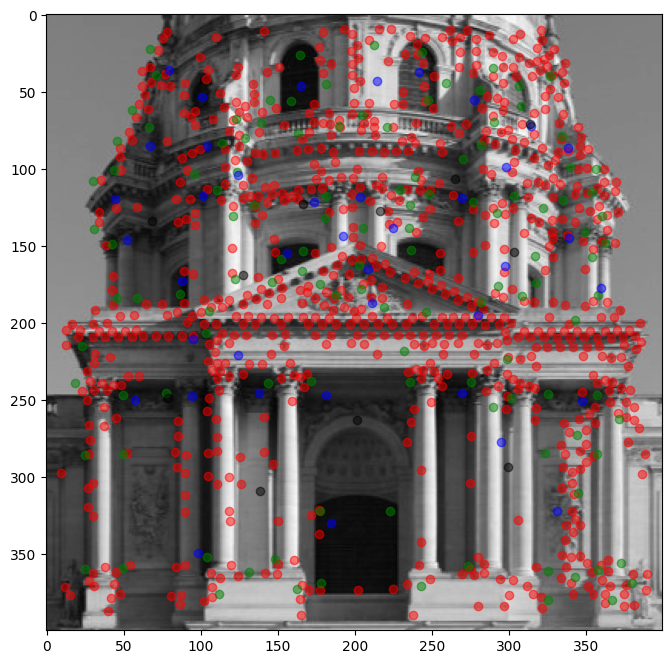

Candidate Keypoint = 973


In [ ]:
import cv2

gimage = cv2.imread('/content/drive/MyDrive/Image/architect2_400.jpg')
gimage = cv2.cvtColor(gimage, cv2.COLOR_BGR2GRAY)

#0 ~ 1 정규화
gimage = gimage / 255.0

kernel = gaussian_filter(1.3)
gray_image = convolve(gimage, kernel)
g_pyramid = generate_gaussian_pyramid(gray_image, num_octave=4, s=5, sigma=1.6)
dog_pyramid = generate_DoG_pyramid(g_pyramid)

R_th = (10+1)**2 / 10
kps = get_keypoints(dog_pyramid, R_th, t_c=0.01, w=16)

myDrawKeypoints(gimage, kps)

print('Candidate Keypoint =', sum(np.array([len(kps[o]) for o in range(len(kps))])))


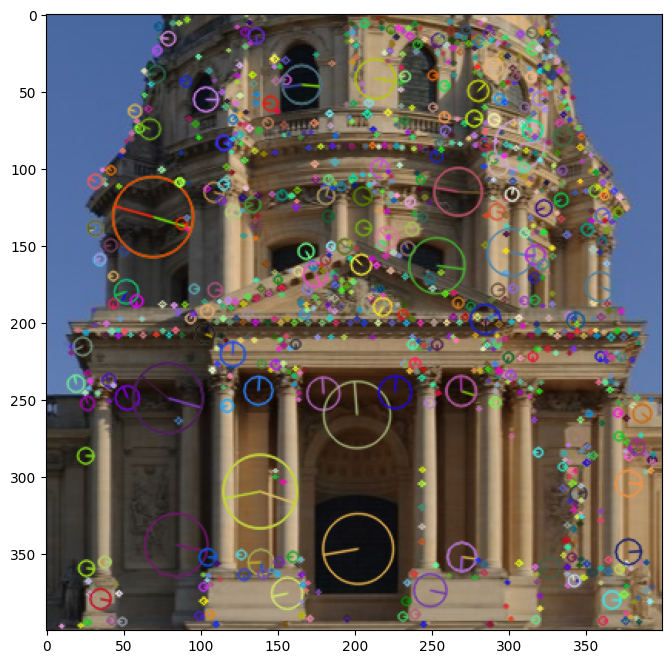

In [ ]:
import cv2

src = cv2.imread('/content/drive/MyDrive/Image/architect2_400.jpg')
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

siftF = cv2.SIFT.create(edgeThreshold=10)
kp_from_sift = siftF.detect(gray)

dst = cv2.drawKeypoints(src, kp_from_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig = plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

# Orientation Assigment



Now we have to obtain the actual descriptors. But before we do so, we need to ensure another type of invariance: rotational.

| 이제 실제 **기술자(descriptor)**를 얻어야 한다. 그러나 그렇게 하기 전에 또 다른 종류의 불변성(invariance)을 보장해야 한다: 회전 불변성(rotational invariance).

We have translational invariance because we convolve our filters over the image. We also have scale invariance because of our use of the scale-normalized LoG filter. Now to impose rotational invariance, **we assign the patch around each keypoint an orientation corresponding to its dominant gradient direction**. This comes in handy later when we use the **Histogram of Gradients descriptor** to describe each patch.

| 우리는 이미지에 필터를 컨볼루션(convolution)하여 이동 불변성(translational invariance)을 이미 갖추었다. 또한, 스케일 정규화된 LoG 필터를 사용하여 스케일 불변성(scale invariance)을 갖추고 있다. 이제 회전 불변성을 적용하기 위해, **각 키포인트 주위의 패치에 대해 해당 키포인트의 주요 기울기 방향에 해당하는 Orientation을 할당**했다. 이것은 나중에 각 패치를 설명하는 데 **Histogram of Gradients 기술자**를 사용할 때 유용하다.

To assign orientation, we take a patch around each keypoint thats size is proportional to the scale of that keypoint. We then create a histogram of the gradients for each pixel in that patch.

| Orientation을 할당하기 위해, 우리는 각 키포인트 주위에 그 키포인트의 스케일에 비례하는 크기의 패치를 취한다. 그런 다음, 그 패치의 각 픽셀에 대해 기울기의 히스토그램을 생성한다.

The histogram is created on angle (the gradient is specified in polar coordinates) and has 36 bins (each bin has a width of 10 degrees). When the magnitude and angle of the gradient at a pixel is calculated, the corresponding bin in our histogram grows by the gradient magnitude weighted by the Gaussian window.

| 히스토그램은 각도(기울기는 극좌표계로 지정됨)를 기준으로 생성되며, 36개의 빈(bin)을 가진다(각 빈의 너비는 10도). 픽셀에서 기울기의 크기와 각도를 계산할 때, 기울기 크기에 해당하는 bin의 히스토그램 값이 가우시안 윈도우로 가중치가 주어져서 증가한다.

Once we have our histogram, we assign that keypoint the orientation of the maximal histogram bin.

| 히스토그램을 얻은 후, 우리는 최대 히스토그램 bin의 Orientation을 해당 특징점에 할당한다.

In [ ]:
def assign_orientation(kps, octave, num_bins=36):
    new_kps = []

    # 히스토그램 bin 너비
    bin_width = 360 // num_bins

    for kp in kps:
        #특징점 kp에서 좌표 추출
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])

        # s가 octave 범위 내에 있도록 함.
        s = np.clip(s, 0, octave.shape[2] - 1)

        # 가우시안 필터 생성
        sigma = kp[2] * 1.5
        w = int(2 * np.ceil(sigma) + 1)
        kernel = gaussian_filter(sigma)

        # 키포인트의 스케일에 해당하는 옥타브 이미지의 2D 슬라이스 L을 선택합니다.
        L = octave[:, :, s]

        hist = np.zeros(num_bins, dtype=np.float32)

        #5. 가우시안 윈도우 내부의 각 픽셀에 대해 연산
        for oy in range(-w, w + 1):
            for ox in range(-w, w + 1):
                #픽셀의 좌표 x, y 계산
                x, y = cx + ox, cy + oy

                #픽셀이 이미지 범위 내에 있는지 확인
                if x < 0 or x >= octave.shape[1] or y < 0 or y >= octave.shape[0]:
                    continue

                # gradient 및 방향 계산
                m, theta = get_grad(L, x, y)

                # 가중치 계산
                weight = kernel[oy + w, ox + w] * m

                # 방향 양자화
                bin = quantize_orientation(theta, num_bins)

                # 히스토그램에 추가
                hist[bin] += weight

        # 히스토그램에서 최대값을 찾고, 키포인트 추가
        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])

        #7. 7. 히스토그램의 다른 빈들을 순회하면서, 최대값의 80% 이상인 빈에 대해서도 키포인트를 new_kps에 추가합니다.

        # 이는 한 키포인트가 여러 개의 우세한 방향을 가질 수 있음을 고려한 것입니다.
        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin:
                continue
            if 0.8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)


The one thing I want to mention about this function is the last loop. The paper specifies that for any histogram bin that has a value within 80% of the maximum value to create a new keypoint at that location and scale but with the new orientation.

The paper also says that you should fit a parabola to the three histogram values closest to the maximum, which is done in the following function:

In [ ]:
def fit_parabola(hist, binno, bin_width):

    centerval = binno*bin_width + bin_width/2.

    if binno == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (binno+1)*bin_width + bin_width/2.

    if binno == 0: leftval = -bin_width/2.
    else: leftval = (binno-1)*bin_width + bin_width/2.

    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])

    b = np.array([
        hist[binno],
        hist[(binno+1)%len(hist)],
        hist[(binno-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]

    if x[0] == 0: x[0] = 1e-6

    return -x[1]/(2*x[0])

We simply get the least squares solution where the center of the max histogram bin as well as its two adjacent bins are taken as the independent variable and the value at that histogram the dependent variable. Once the coefficients for the parabola have been found, just use -b/2a to get the refined orientation.

### Side notes : A parabola fitting with three points

일반적인 2차 함수는 다음과 같이 표현된다:

$$
y = ax^2 + bx + c
$$

포물선 위의 세 점  $(x_1, y_1), (x_2, y_2), (x_3, y_3)$ 을 이용해 다음과 같은 방정식을 세울 수 있다.


$$
y_1 = ax_1^2 + bx_1 + c
$$

$$
y_2 = ax_2^2 + bx_2 + c
$$

$$
y_3 = ax_3^2 + bx_3 + c
$$

이 방정식을 행렬로 표현하면 다음과 같다:

$$
\begin{bmatrix}
y_1 \\
y_2 \\
y_3
\end{bmatrix}
=
\begin{bmatrix}
x_1^2 & x_1 & 1 \\
x_2^2 & x_2 & 1 \\
x_3^2 & x_3 & 1
\end{bmatrix}
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
$$

$$
\text{이를 다시 정리하면, }
$$

$$
\mathbf{b} = A \mathbf{x}
$$

$$
\mathbf{x} = \begin{bmatrix} a \\ b \\ c \end{bmatrix}, \quad \mathbf{b} = \begin{bmatrix} y_1 \\ y_2 \\ y_3 \end{bmatrix}, \quad A = \begin{bmatrix} x_1^2 & x_1 & 1 \\ x_2^2 & x_2 & 1 \\ x_3^2 & x_3 & 1 \end{bmatrix}
$$

이 행렬 방정식을 풀면 포물선의 계수 $a, b, c$ 는 다음과 같이 구할 수 있다:

$$
\mathbf{x} = A^{-1} \mathbf{b}
$$

포물선의 꼭짓점 위치는 다음과 같다:


$$
x_{\text{vertex}} = -\frac{b}{2a}
$$


There are also a few functions not included in this code. First is `get_grads` , which gets the gradient in polar coordinates at a pixel in $L$:

In [ ]:
def cart_to_polar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta

def get_grad(L, x, y):

    #min과 max 함수는 이미지의 경계를 넘어서는 인덱스 접근을 방지하기 위해 사용
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    return cart_to_polar_grad(dx, dy)

Then there is quantize_orientation, which simply converts the continuous angle of the gradient to a histogram bin:

In [ ]:
def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins

    #내림 연산 수행 np.floor & quntization
    return int(np.floor(theta)//bin_width)

# Local Descriptor Creation

Finally, we can create the local descriptors for each keypoint. As previously mentioned, we use the Histogram of Gradients method to create a feature vector from the surroundings of each keypoint.

Specifically, a 16x16 patch is inspected around each keypoint. That patch is then split up into 16 4x4 subregions. The gradients (in polar coordinates) of each subregion are then binned into an 8-bin histogram. Finally, all of these histograms are concatenated into a 4x4x8=128 element long feature vector.

This final feature vector is then normalized, thresholded, and renormalized to try and ensure invariance to minor lighting changes.

In [ ]:
def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):

    descs = []
    bin_width = 360//num_bin

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)

        kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3
        L = octave[:, :, s]

        t, l = max(0, cy-w//2), max(0, cx-w//2)
        b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
        patch = L[t:b, l:r]
        dx, dy = get_patch_grads(patch)

        if dx.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:]
            else: kernel = kernel[:dx.shape[0]]

        if dx.shape[1] < w+1:
            if l == 0: kernel = kernel[:, kernel.shape[1]-dx.shape[1]:]
            else: kernel = kernel[:, :dx.shape[1]]

        if dy.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:]
            else: kernel = kernel[:dy.shape[0]]

        if dy.shape[1] < w+1:
            if l == 0: kernel = kernel[:, kernel.shape[1]-dy.shape[1]:]
            else: kernel = kernel[:, :dy.shape[1]]

        m, theta = cart_to_polar_grad(dx, dy)
        dx, dy = dx*kernel, dy*kernel

        subregion_w = w//num_subregion

        #128차원 벡터를 1차원 행렬로 받음.
        featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), theta[t:b, l:r].ravel(), num_bin, kp[3], bin_width, subregion_w)

                featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

        #featvet은 numpy 즉 float32이므로 float으로 형 변환해야함.
        #featvec/유클리드 norm = 단위 벡터로 정규화. (norm = 1)
        #featvec 의 각 방향성분은 0~1 사이의 값이 되겠지?
        featvec /= max(1e-6, float(LA.norm(featvec)))

        #불리언 인덱싱으로 거르기
        featvec[featvec>0.2] = 0.2

        #다시 단위 벡터로 정규화
        featvec /= max(1e-6, float(LA.norm(featvec)))
        descs.append(featvec)

    return np.array(descs)

The checks on the shape of dx and dy in the middle are to avoid out of bounds errors I was getting earlier. If either/or are smaller than w+1 then cut off the Gaussian window accordingly to avoid shape mismatches.

| 중간의 dx, dy의 형태를 체크하는 것은 경계 에러를 피하기 위함이다. dx 또는 dy 중 하나라도 w+1보다 작으면, 모양 불일치를 피하기 위해 가우시안 윈도를 적절히 잘라내야한다.

First, the polar gradients are computed for the whole patch. Then the histogram is created for each subregion. Once the histogram for each subregion has been concatenated, the entire feature vector is normalized, thresholded to be less than or equal to 0.2, and then renormalized.

| 먼저, 전체 패치에 대해 극좌표 그래디언트를 계산한다. 그런 다음 각 subregion에 대해 히스토그램을 생성한다. 각 subregion의 히스토그램이 연결된 후, 전체 특징 벡터가 정규화되고, 0.2 이하로 임계값을 적용한 다음 다시 정규화한다. (이로써 회전불변성을 갖춘다.)

I’m not 100% certain on the motivation behind the thresholding and renormalization but I believe it helps provide invariance to nonlinear lighting changes.

To calculate the gradients across the patch:

In [ ]:
def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2

    r1[:,-1] = p[:,-1]
    r1[:,:-1] = p[:,1:]
    r2[:,0] = p[:,0]
    r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy


Just take the difference between the previous and current pixels. This is easier than doing the double-sided derivative as before. Then to create the histogram for each subregion:

| 이전과 현재 픽셀 간의 차이를 구하기만 하면 된다. 이전에 했던 것처럼 양방향 도함수를 계산하는 것보다 더 쉽다. 그런 다음 각 subregion에 대한 히스토그램을 생성한다

In [ ]:
def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):

    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle - reference_angle) % 360 #0 ~ 359
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        #각도 보간 가중치 계산(빈의 중심에 가까울 수록 가중치 up)
        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        #픽셀의 좌표를 계산(np.unravel_index)
        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))

        #공간 보간
        #픽셀이 서브리전의 중심에서 얼마나 떨어져 있는지에 따라 x와 y 방향의 가중치를 계산
        x_interp_weight = max(1 - abs(gx - c) / c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c) / c, 1e-6)

        #가중치를 적용
        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    hist /= max(1e-6, float(LA.norm(hist)))

    #히스토그램의 각 요소가 0.2를 넘지 않도록 클리핑. 이는 밝은 영역에서 특징이 과도하게 강조되는 것을 방지하기 위함임.
    hist[hist>0.2] = 0.2

    hist /= max(1e-6, float(LA.norm(hist)))
    return hist

The code is fairly similar to the previous HoG code however we perform trilinear interpolation on each entry into the histogram. This interpolation is to provide robustness for when a gradient at a pixel either goes from one bin to the other or is at the edge of a subregion and goes into a different subregion.


| 코드는 이전 HoG 코드와 상당히 유사하지만, 우리는 히스토그램의 각 항목에 대해 삼선형 보간을 수행한다. 이 보간은 픽셀에서의 그래디언트가 한 bin에서 다른 bin으로 이동하거나 subregion의 경계에 있어 다른 subregion 으로 넘어가는 경우의 robustness을 제공하기 위한 것이다.


Therefore, the weight of an entry is proportional to 1-(distance from the center of the bin) and well as 1-(distance from the center of the subregion) for both the x and y directions. The spatial (x and y) interpolation is the only thing I am not sure about because I could not find a reliable source on it.

| 따라서 항목의 가중치는 bin의 중심으로부터의 거리와 x 및 y 방향에서 subregion 중심으로부터의 거리에 대해 각각 1-(거리)와 비례한다. [공간적 보간(x 및 y 방향)은 제가 확신하지 못하는 부분인데, 이와 관련하여 신뢰할 만한 출처를 찾지 못했기 때문이다.]

# Putting it All Together

We can now create a `SIFT` object to encapsulate all of the above operations:

In [ ]:
class SIFT(object):
    def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16):
        self.im = convolve(rgb2gray(im), gaussian_filter(s0))
        self.s = s
        self.sigma = sigma
        self.num_octave = num_octave
        self.t_c = t_c
        self.R_th = (r_th+1)**2 / r_th
        self.w = w

    def get_features(self):
        gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma)
        DoG_pyr = generate_DoG_pyramid(gaussian_pyr)
        kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w)
        feats = []
        for i, DoG_octave in enumerate(DoG_pyr): kp_pyr[i] =
        assign_orientation(kp_pyr[i], DoG_octave)
        feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))
        self.kp_pyr = kp_pyr
        self.feats = feats
        return feats

One final small detail is that I blur the initial image with a sigma of 1.3. I did not see this in the paper but I saw it in a few implementations.

#Match

In [ ]:
def get_features(fnames):
    ims = []

    kp_feats = []
    kp_ptrs = []

    for i, fname in enumerate(fnames):
        im = cv2.imread(fname)
        ims.append(im)
        gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        sift_detector = SIFT(gray_image)
        _ = sift_detector.get_features()

        feats = sift_detector.feats
        pyrs = sift_detector.kp_pyr

        featsAcc = []  # Use a list to accumulate features
        ptrsAcc = []   # Use a list to accumulate keypoints

        for oct_i, oct_v in enumerate(pyrs):
            kps = oct_v * (2 ** oct_i)

            if feats[oct_i].size > 0:
                featsAcc.append(feats[oct_i])
                ptrsAcc.append(kps)

        if featsAcc:  # Only append if featsAcc is not empty
            kp_feats.append(np.vstack(featsAcc))
            kp_ptrs.append(np.vstack(ptrsAcc))

    return ims, kp_ptrs, kp_feats

def get_matches(feats1, feats2, ratio=0.8):
    idxs1, idxs2 = [], []
    for i, feat in enumerate(feats1):
        #Euclidian Distance
        distances = LA.norm(feats2 - feat, axis=1)

        #NNDR 방식
        nn = np.argsort(distances)[:2]
        dist1, dist2 = distances[nn[0]], distances[nn[1]]

        if dist1/max(1e-6, dist2)  < ratio:
            idxs1.append(i)
            idxs2.append(nn[0])

    return idxs1, idxs2

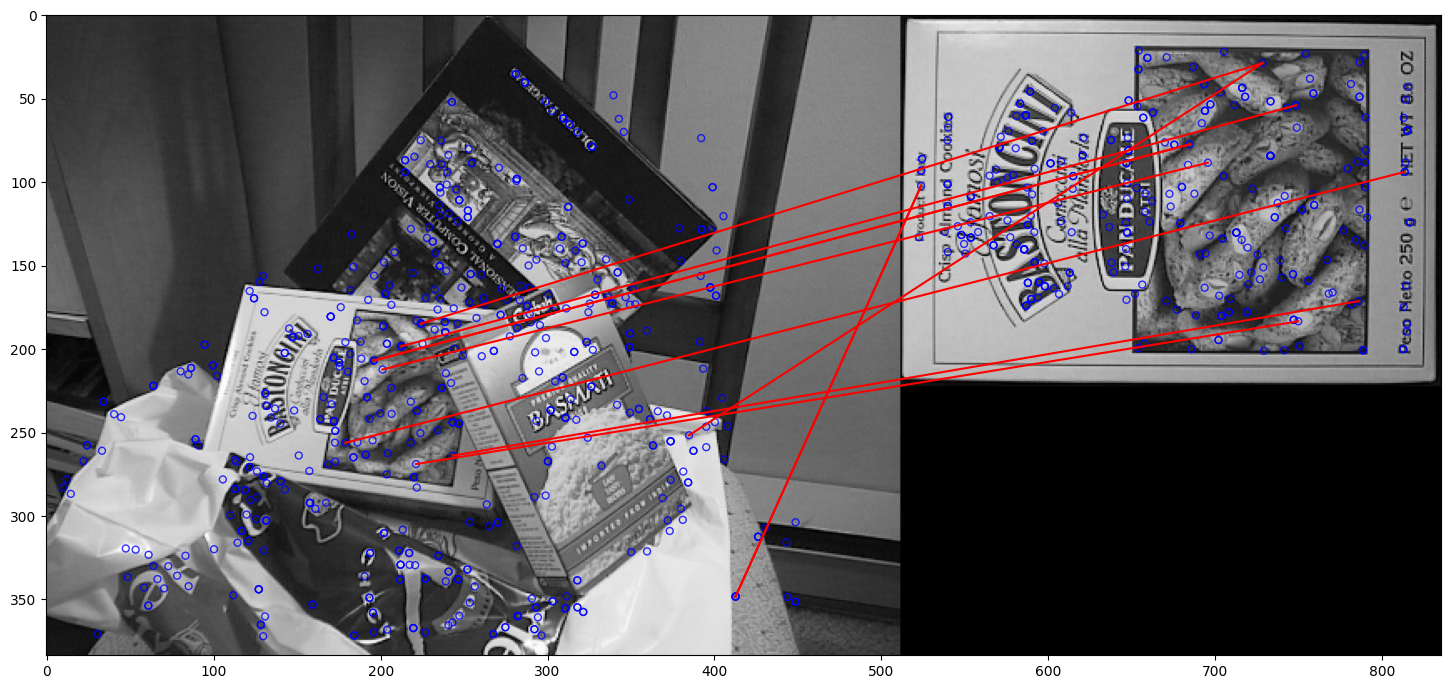

In [ ]:
fnames = ['/content/drive/MyDrive/Image/box_in_scene.png', '/content/drive/MyDrive/Image/box.png']

ims, kp_ptrs, kp_feats = get_features(fnames)
idxs1, idxs2 = get_matches(kp_feats[0], kp_feats[1])

row1, col1 = ims[0].shape[:2]
row2, col2 = ims[1].shape[:2]

stackedImage = np.zeros((max(row1, row2), col1+col2, ims[0].shape[2]),dtype=ims[0][0, 0, 0].dtype)

stackedImage[:row1, :col1, :] = ims[0]
stackedImage[:row2, col1: col1 + col2, :] = ims[1]

_, ax = plt.subplots(1, 1, figsize=(18, 12))
ax.imshow(stackedImage)
ax.scatter(kp_ptrs[0][:, 0], kp_ptrs[0][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)
ax.scatter(kp_ptrs[1][:, 0] + col1, kp_ptrs[1][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)

for i in range(len(idxs1)):
    kps1 = kp_ptrs[0][idxs1[i]]
    kp2s = kp_ptrs[1][idxs2[i]]
    x1, y1 = (kps1[0], kps1[1])
    x2, y2 = (kp2s[0] + col1, kp2s[1])
    ax.plot([x1, x2], [y1, y2], 'r')


plt.show()

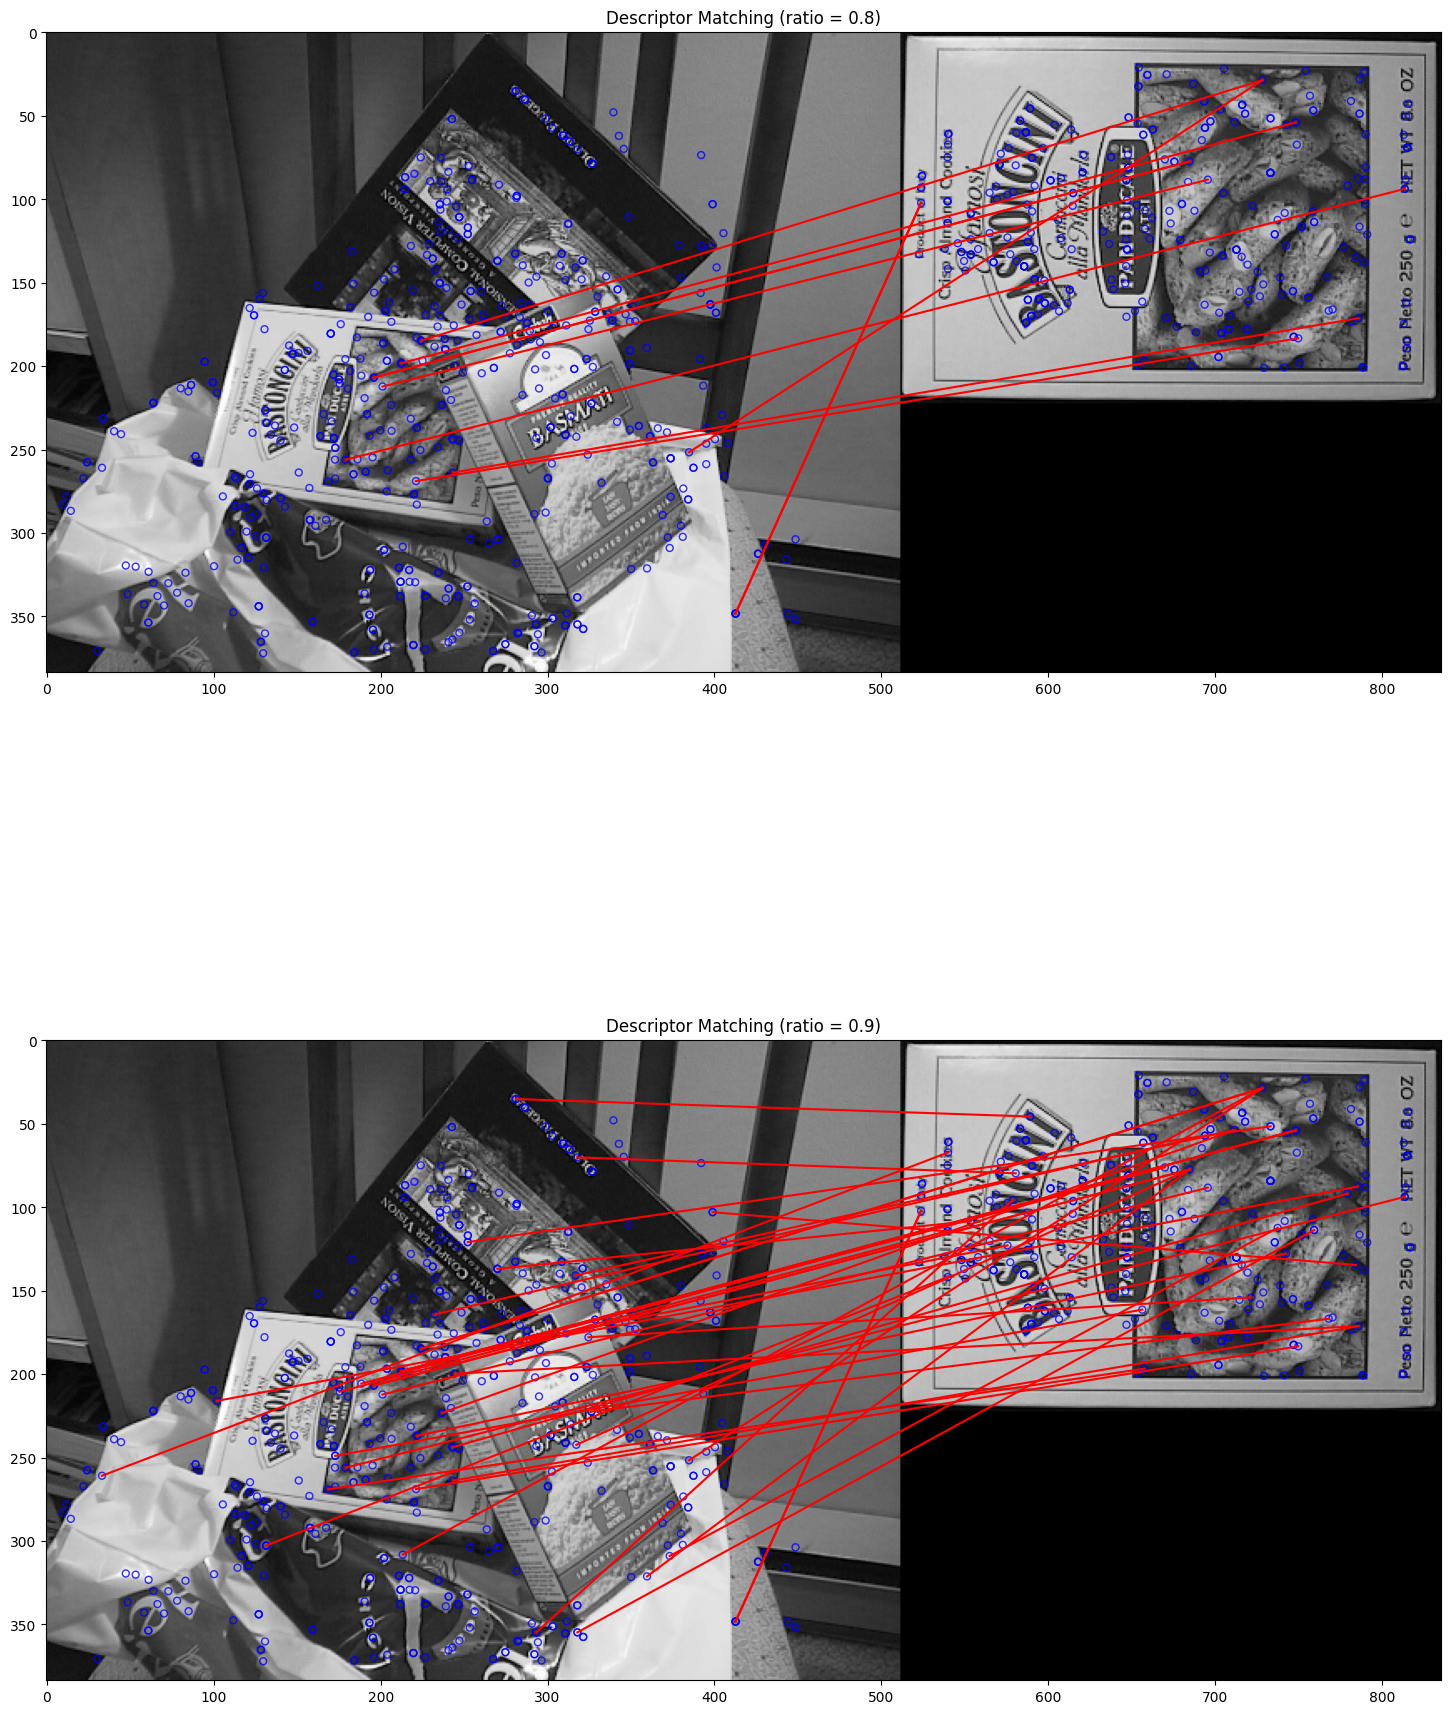

In [ ]:
def stack_images(im1, im2):
    im1_size = im1.shape[:2]
    im2_size = im2.shape[:2]
    stacked_image = np.zeros((max(im1_size[0], im2_size[0]), im1_size[1] + im2_size[1], im1.shape[2]),
                             dtype=im1.dtype)
    stacked_image[:im1_size[0], :im1_size[1], :] = im1
    stacked_image[:im2_size[0], im1_size[1]:im1_size[1] + im2_size[1], :] = im2
    return stacked_image

fnames = ['/content/drive/MyDrive/Image/box_in_scene.png', '/content/drive/MyDrive/Image/box.png']

# 첫 번째 이미지 세트의 특징 및 매칭
feat_first = get_features(fnames)
feat_first_ratio = 0.8
idxs_first = get_matches(feat_first[2][0], feat_first[2][1], feat_first_ratio)

# 두 번째 이미지 세트의 특징 및 매칭
feat_second = get_features(fnames)
feat_second_ratio = 0.9
idxs_second = get_matches(feat_second[2][0], feat_second[2][1], feat_second_ratio)

# 이미지 스태킹
stacked_first_image = stack_images(feat_first[0][0], feat_first[0][1])
stacked_second_image = stack_images(feat_second[0][0], feat_second[0][1])

# 서브플롯 설정
fig, axs = plt.subplots(2, 1, figsize=(18, 24))

# 첫 번째 이미지 세트의 매칭 시각화
axs[0].imshow(stacked_first_image)
axs[0].set_title(f'Descriptor Matching (ratio = {feat_first_ratio})')
col1_first = feat_first[0][0].shape[1]
kp_ptrs_first = feat_first[1]

axs[0].scatter(kp_ptrs_first[0][:, 0], kp_ptrs_first[0][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)
axs[0].scatter(kp_ptrs_first[1][:, 0] + col1_first, kp_ptrs_first[1][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)

for i in range(len(idxs_first[0])):
    kps1 = kp_ptrs_first[0][idxs_first[0][i]]
    kps2 = kp_ptrs_first[1][idxs_first[1][i]]
    x1, y1 = kps1[0], kps1[1]
    x2, y2 = kps2[0] + col1_first, kps2[1]
    axs[0].plot([x1, x2], [y1, y2], 'r')

# 두 번째 이미지 세트의 매칭 시각화
axs[1].imshow(stacked_second_image)
axs[1].set_title(f'Descriptor Matching (ratio = {feat_second_ratio})')
col1_second = feat_second[0][0].shape[1]
kp_ptrs_second = feat_second[1]

axs[1].scatter(kp_ptrs_second[0][:, 0], kp_ptrs_second[0][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)
axs[1].scatter(kp_ptrs_second[1][:, 0] + col1_second, kp_ptrs_second[1][:, 1], s=25, facecolors='none', edgecolors='b', alpha=0.8)

for i in range(len(idxs_second[0])):
    kps1 = kp_ptrs_second[0][idxs_second[0][i]]
    kps2 = kp_ptrs_second[1][idxs_second[1][i]]
    x1, y1 = kps1[0], kps1[1]
    x2, y2 = kps2[0] + col1_second, kps2[1]
    axs[1].plot([x1, x2], [y1, y2], 'r')

plt.show()

# Conclusion

I know this has been really long and probably not all that clear in places, but I hope you learned something about both the theory and how to implement SIFT.

I’m aware that this is not a perfect implementation and nor does it implement every detail from the paper, but it empirically seems to work pretty well, whatever that means.`

### Multivariable quadratic approximation

2nd order taylor expansion
* 함수 $f(x)$를 특정 점 $x = a$ 근처에서 다항식으로 근사하는 방법

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9w3vFLk33tRI8fAAhuhL-VU-JiftojsTj1w&s)

Maclaurin expansion

* 함수 $f(x)$를 $x = 0$ 근처에서 다항식으로 근사하는 방법

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZKkfOC7YFZso1giZko0-xncnmdRCIYzrvWg&s)

multivariable quadratic approximation (two variable case)